# Models for XRP (contd)

Emily collected some measurements for XRP, specifically for basalt, dunite and granite. Repeat all the modelling for these three files

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn

import matplotlib

In [1]:
# imports for the rocky_exo environment

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import numpy as np
from spectres import spectres 
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyutils
from scipy.special import lambertw as W
from scipy.special import erfcinv
import warnings

In [2]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

## Generate models for basalt, white marble, and basalt (their emissivities have prominent features and look separate)

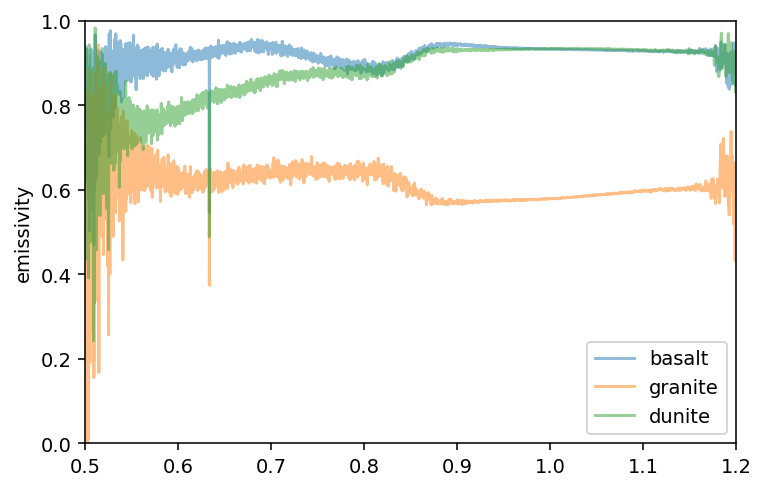

In [12]:
### load emissivity data

eps_basalt_mir = np.loadtxt('data_Emily/xrp_samples/data/basaltMIR_emi.txt', delimiter=',')
wav_basalt_mir, eps_basalt_mir  = eps_basalt_mir[:,0][::-1], eps_basalt_mir[:,1][::-1]

eps_basalt_vnir = np.loadtxt('data_Emily/xrp_samples/data/basaltVNIR_emi.txt', delimiter=',')
wav_basalt_vnir, eps_basalt_vnir  = eps_basalt_vnir[:,0][::-1], eps_basalt_vnir[:,1][::-1]

eps_granite_mir = np.loadtxt('data_Emily/xrp_samples/data/graniteMIR_emi.txt', delimiter=',')
wav_granite_mir, eps_granite_mir  = eps_granite_mir[:,0][::-1], eps_granite_mir[:,1][::-1]

eps_granite_vnir = np.loadtxt('data_Emily/xrp_samples/data/graniteVNIR_emi.txt', delimiter=',')
wav_granite_vnir, eps_granite_vnir  = eps_granite_vnir[:,0][::-1], eps_granite_vnir[:,1][::-1]

eps_dunite_mir = np.loadtxt('data_Emily/xrp_samples/data/duniteMIR_emi.txt', delimiter=',')
wav_dunite_mir, eps_dunite_mir  = eps_dunite_mir[:,0][::-1], eps_dunite_mir[:,1][::-1]

eps_dunite_vnir = np.loadtxt('data_Emily/xrp_samples/data/duniteVNIR_emi.txt', delimiter=',')
wav_dunite_vnir, eps_dunite_vnir  = eps_dunite_vnir[:,0][::-1], eps_dunite_vnir[:,1][::-1]


plt.figure()
plt.plot(wav_basalt_vnir, eps_basalt_vnir, alpha=0.5, label='basalt')
plt.plot(wav_granite_vnir, eps_granite_vnir, alpha=0.5, label='granite')
plt.plot(wav_dunite_vnir, eps_dunite_vnir, alpha=0.5, label='dunite')
plt.xlim((0.5,1.2))
plt.ylim((0,1))
plt.ylabel('emissivity')
plt.legend()


From this emissivity plot, we can roughly assume the following albedos (1 - emissivity):

1. basalt = 0.05
2. granite = 0.4
3. dunite = 0.25

In [19]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star

A_basalt = 0.0 
A_dunite = 0.4 
A_granite = 0.25 

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_dunite = T_star*np.sqrt(R_star/(2*a))*(1 - A_dunite)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)

In [20]:
T_basalt, T_granite, T_dunite

(809.1541889477488, 753.0028199975934, 712.1460985684528)

In [21]:
#### Produce planetary emission models for these three rock types

wav_basalt, eps_basalt = wav_basalt_mir, eps_basalt_mir
wav_granite, eps_granite = wav_granite_mir, eps_granite_mir
wav_dunite, eps_dunite = wav_dunite_mir, eps_dunite_mir

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
#T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(4*np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

stellar_fudge_factor = 4   # a fudge factor to get the stellar grid model to match the blackbody model (see the other notebook)

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_fudge_factor*spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_dunite, wav_stellar, spec_stellar)
spec_dunite = fp_over_fstar(wav_dunite*10**-6, R_p, D_p, eps_dunite, stellar_fudge_factor*spec_stellar_grid, T_dunite, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, D_p, eps_granite, stellar_fudge_factor*spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



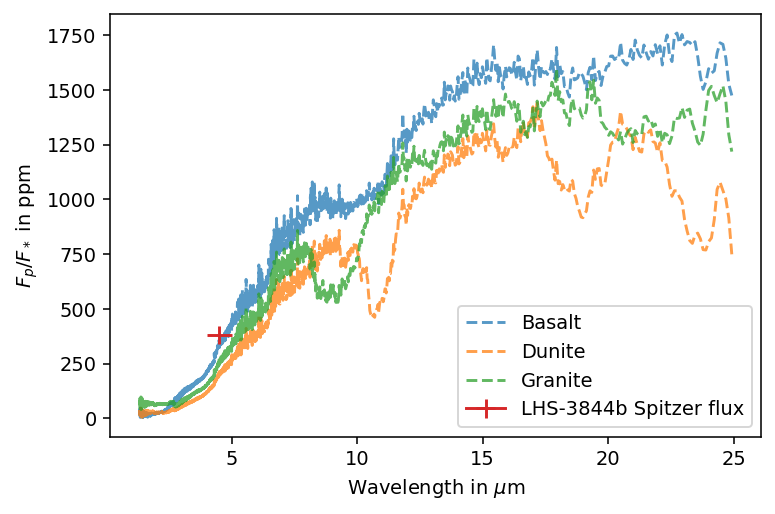

In [23]:
plt.figure()
planetary_fudge_factor = 2.0
plt.plot(wav_basalt, planetary_fudge_factor*spec_basalt*10**6, ls='--', alpha=0.75, label='Basalt')
plt.plot(wav_dunite, planetary_fudge_factor*spec_dunite*10**6, ls='--', alpha=0.75, label='Dunite')
plt.plot(wav_granite, planetary_fudge_factor*spec_granite*10**6, ls='--', alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

Okay, these fudged models should work fine for now (-_-). Let's write them into files so that pandexo can use them

In [24]:
# write the model spectra into .txt files with column-1 as wavelength and column-2 as F_p/F_star

file_prefix = 'simulated_data/xrp/'
np.savetxt(file_prefix +'basalt.txt', np.array([wav_basalt, planetary_fudge_factor*spec_basalt]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix +'dunite.txt', np.array([wav_dunite, planetary_fudge_factor*spec_dunite]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix +'granite.txt', np.array([wav_granite, planetary_fudge_factor*spec_granite]).T, delimiter='\t', fmt='%s')

### Let's now run pandexo simulations for these models

In [25]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# basalt
exo_dict_basalt = copy.deepcopy(exo_dict)
exo_dict_basalt['planet']['exopath'] = './simulated_data/xrp/basalt.txt'

# white marble
exo_dict_dunite = copy.deepcopy(exo_dict)
exo_dict_dunite['planet']['exopath'] = './simulated_data/xrp/dunite.txt'

# granite
exo_dict_granite = copy.deepcopy(exo_dict)
exo_dict_granite['planet']['exopath'] = './simulated_data/xrp/granite.txt'

In [26]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for basalt

result = jdi.run_pandexo(exo_dict_basalt, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_basalt.p')
result = jdi.run_pandexo(exo_dict_dunite, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_dunite.p')
result = jdi.run_pandexo(exo_dict_granite, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_granite.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


Load and plot data

In [29]:
R = 50

# load outputs from run

out_basalt = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_basalt.p','rb'))
x_basalt_5,y_basalt_5,e_basalt_5 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=5, model=True, plot=False)
x_basalt_10,y_basalt_10,e_basalt_10 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=10, model=True, plot=False)

out_granite = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_granite.p','rb'))
x_granite_5,y_granite_5,e_granite_5 = jpi.jwst_1d_spec(out_granite, R=R/2, num_tran=5, model=True, plot=False)
x_granite_10,y_granite_10,e_granite_10 = jpi.jwst_1d_spec(out_granite, R=R/2, num_tran=10, model=True, plot=False)

out_dunite = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_dunite.p','rb'))
x_dunite_5,y_dunite_5,e_dunite_5 = jpi.jwst_1d_spec(out_dunite, R=R/2, num_tran=5, model=True, plot=False)
x_dunite_10,y_dunite_10,e_dunite_10 = jpi.jwst_1d_spec(out_dunite, R=R/2, num_tran=10, model=True, plot=False)

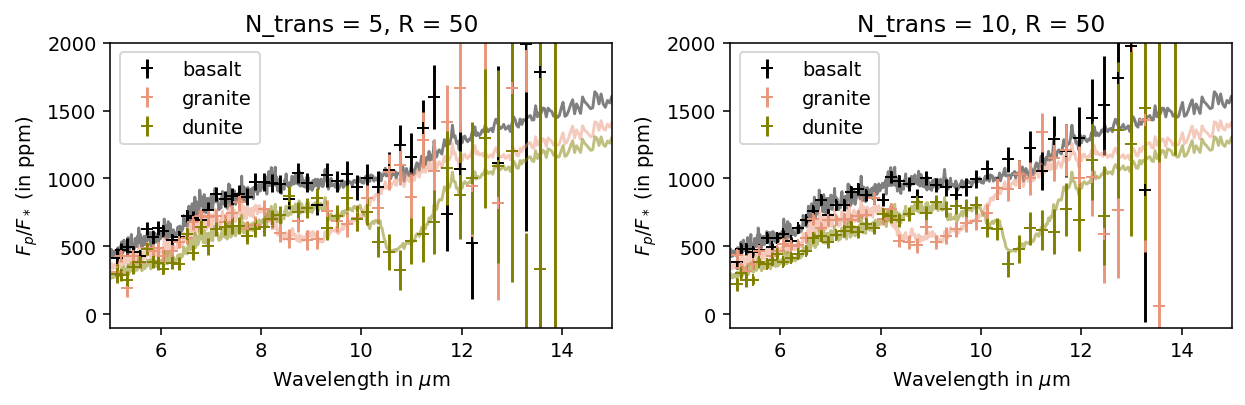

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt(exo_dict_basalt['planet']['exopath'])
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt(exo_dict_dunite['planet']['exopath'])
wav_dunite, spec_dunite = data[:,0], data[:,1]

data = np.loadtxt(exo_dict_granite['planet']['exopath'])
wav_granite, spec_granite = data[:,0], data[:,1]

data_color_basalt= 'black'
data_color_dunite = 'olive'
data_color_granite = 'darksalmon'

ax[0].errorbar(x_basalt_5[0],10**6*y_basalt_5[0], yerr=10**6*e_basalt_5[0], ls='', fmt='+', label='basalt', color=data_color_basalt)
ax[0].plot(wav_basalt, 10**6*spec_basalt, color=data_color_basalt,  alpha = 0.5)
ax[0].errorbar(x_granite_5[0],10**6*y_granite_5[0], yerr=10**6*e_granite_5[0], ls='', fmt='+', label='granite', color=data_color_granite)
ax[0].plot(wav_granite, 10**6*spec_granite, color=data_color_granite,  alpha = 0.5)
ax[0].errorbar(x_dunite_5[0],10**6*y_dunite_5[0], yerr=10**6*e_dunite_5[0], ls='', fmt='+', label='dunite', color=data_color_dunite)
ax[0].plot(wav_dunite, 10**6*spec_dunite, color=data_color_dunite,  alpha = 0.5)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('N_trans = 5, R = 50')
ax[0].legend()

ax[1].errorbar(x_basalt_10[0],10**6*y_basalt_10[0], yerr=10**6*e_basalt_10[0], ls='', fmt='+', label='basalt', color=data_color_basalt)
ax[1].plot(wav_basalt, 10**6*spec_basalt, color=data_color_basalt,  alpha = 0.5)
ax[1].errorbar(x_granite_10[0],10**6*y_granite_10[0], yerr=10**6*e_granite_10[0], ls='', fmt='+', label='granite', color=data_color_granite)
ax[1].plot(wav_granite, 10**6*spec_granite, color=data_color_granite,  alpha = 0.5)
ax[1].errorbar(x_dunite_10[0],10**6*y_dunite_10[0], yerr=10**6*e_dunite_10[0], ls='', fmt='+', label='dunite', color=data_color_dunite)
ax[1].plot(wav_dunite, 10**6*spec_dunite, color=data_color_dunite,  alpha = 0.5)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('N_trans = 10, R = 50')
ax[1].legend()

plt.tight_layout()

## Now onto the Moon spectrum!

### Plot LHS3844b like models for all of them and compare

In [37]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star

A_basalt = 0.0 
A_dunite = 0.4 
A_granite = 0.25 
A_moon = 0.1 # lunar mare is very dark; albedo similar to mercury 
            # (https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.726.2527&rep=rep1&type=pdf)

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_dunite = T_star*np.sqrt(R_star/(2*a))*(1 - A_dunite)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)
T_moon = T_star*np.sqrt(R_star/(2*a))*(1 - A_moon)**(0.25)

In [38]:
# load and redefine emissivity arrays

eps_moon = np.loadtxt('Resources/moon_soil_emissivity.csv', delimiter=',')
wav_moon, eps_moon  = eps_moon[:,0], eps_moon[:,1]

wav_basalt, eps_basalt = wav_basalt_mir, eps_basalt_mir
wav_granite, eps_granite = wav_granite_mir, eps_granite_mir
wav_dunite, eps_dunite = wav_dunite_mir, eps_dunite_mir

In [39]:
#### Produce planetary emission models for these three rock types

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
#T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(4*np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

stellar_fudge_factor = 4   # a fudge factor to get the stellar grid model to match the blackbody model (see the other notebook)

### Calculate moon model

spec_stellar_grid = spectres(wav_moon, wav_stellar, spec_stellar)
spec_moon = fp_over_fstar(wav_moon*10**-6, R_p, D_p, eps_moon, stellar_fudge_factor*spec_stellar_grid, T_moon, R_star, constant_T=True)

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_fudge_factor*spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_dunite, wav_stellar, spec_stellar)
spec_dunite = fp_over_fstar(wav_dunite*10**-6, R_p, D_p, eps_dunite, stellar_fudge_factor*spec_stellar_grid, T_dunite, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, D_p, eps_granite, stellar_fudge_factor*spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



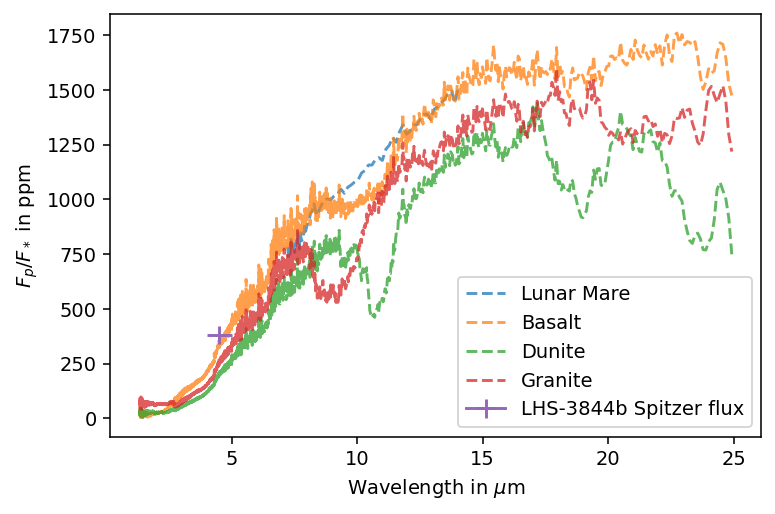

In [40]:
plt.figure()
planetary_fudge_factor = 2.0
plt.plot(wav_moon, planetary_fudge_factor*spec_moon*10**6, ls='--', alpha=0.75, label='Lunar Mare')
plt.plot(wav_basalt, planetary_fudge_factor*spec_basalt*10**6, ls='--', alpha=0.75, label='Basalt')
plt.plot(wav_dunite, planetary_fudge_factor*spec_dunite*10**6, ls='--', alpha=0.75, label='Dunite')
plt.plot(wav_granite, planetary_fudge_factor*spec_granite*10**6, ls='--', alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend(loc='lower right')

### Now produce data using the Moon model and overplot the basalt model to it

In [41]:
# write the moon model spectrum into .txt files with column-1 as wavelength and column-2 as F_p/F_star

file_prefix = 'simulated_data/xrp/'
np.savetxt(file_prefix +'moon.txt', np.array([wav_moon, planetary_fudge_factor*spec_moon]).T, delimiter='\t', fmt='%s')

In [42]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# moon
exo_dict['planet']['exopath'] = './simulated_data/xrp/moon.txt'

In [44]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for basalt

result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_moon.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [37]:
R = 50

# load outputs from run

out_moon = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_moon.p','rb'))
x_moon_5,y_moon_5,e_moon_5 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=5, model=True, plot=False)
x_moon_10,y_moon_10,e_moon_10 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=10, model=True, plot=False)

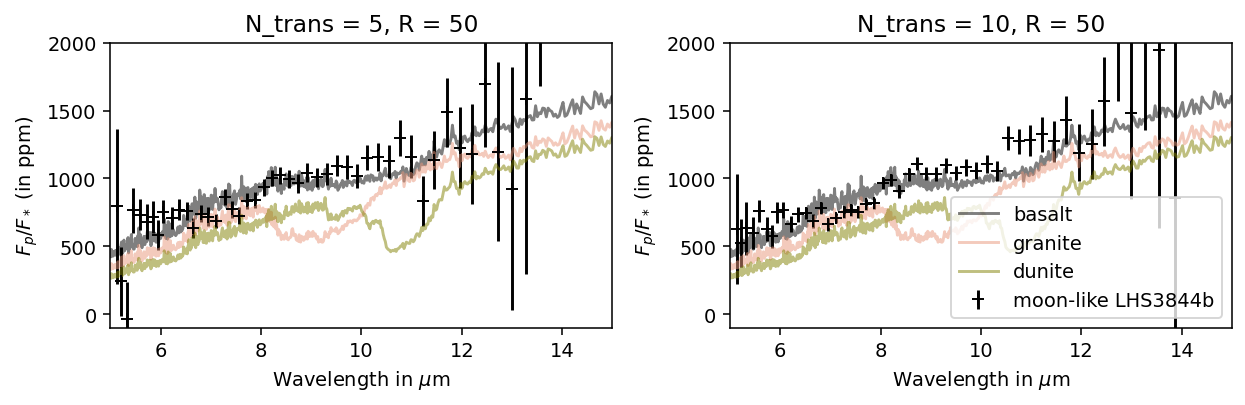

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt('./simulated_data/xrp/basalt.txt')
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/dunite.txt')
wav_dunite, spec_dunite = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/granite.txt')
wav_granite, spec_granite = data[:,0], data[:,1]

color_basalt= 'black'
color_dunite = 'olive'
color_granite = 'darksalmon'

ax[0].errorbar(x_moon_5[0],10**6*y_moon_5[0], yerr=10**6*e_moon_5[0], ls='', fmt='+', label='moon-like LHS3844b', color='black')
ax[0].plot(wav_basalt, 10**6*spec_basalt, color=color_basalt,  alpha = 0.5, label='basalt')
ax[0].plot(wav_granite, 10**6*spec_granite, color=color_granite,  alpha = 0.5, label='granite')
ax[0].plot(wav_dunite, 10**6*spec_dunite, color=color_dunite,  alpha = 0.5, label='dunite')
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('N_trans = 5, R = 50')
#ax[0].legend(loc='lower right')

ax[1].errorbar(x_moon_10[0],10**6*y_moon_10[0], yerr=10**6*e_moon_10[0], ls='', fmt='+', label='moon-like LHS3844b', color='black')
ax[1].plot(wav_basalt, 10**6*spec_basalt, color=color_basalt,  alpha = 0.5, label='basalt')
ax[1].plot(wav_granite, 10**6*spec_granite, color=color_granite,  alpha = 0.5, label='granite')
ax[1].plot(wav_dunite, 10**6*spec_dunite, color=color_dunite,  alpha = 0.5, label='dunite')
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('N_trans = 10, R = 50')
ax[1].legend(loc='lower right')

plt.tight_layout()

Basalt is clearly preferred. How well are the granite and dunite models rejected?


In [41]:
# calculate average noise level of the moon data between 8 and 10 microns

ind = np.where((x_moon_5[0] > 8) & (x_moon_5[0] < 11))
avg_noise_5 = np.mean(10**6*e_moon_5[0][ind])


ind = np.where((x_moon_10[0] > 8) & (x_moon_10[0] < 11))
avg_noise_10 = np.mean(10**6*e_moon_10[0][ind])

# calculate average flux levels of granite and white marble models between 8 and 10 microns

ind = np.where((wav_granite > 8) & (wav_granite < 11))
avg_flux_granite = np.mean(10**6*spec_granite[ind])

ind = np.where((wav_dunite > 8) & (wav_dunite < 11))
avg_flux_dunite = np.mean(10**6*spec_dunite[ind])

ind = np.where((wav_basalt > 8) & (wav_basalt < 11))
avg_flux_basalt = np.mean(10**6*spec_basalt[ind])

print('For N_trans = 5:')
print('Granite model rejected at ', (avg_flux_basalt - avg_flux_granite)/avg_noise_5, ' sigma level')
print('Dunite model rejected at ', (avg_flux_basalt - avg_flux_dunite)/avg_noise_5, ' sigma level')

print('For N_trans = 10:')
print('Granite model rejected at ', (avg_flux_basalt - avg_flux_granite)/avg_noise_10, ' sigma level')
print('Dunite model rejected at ', (avg_flux_basalt - avg_flux_dunite)/avg_noise_10, ' sigma level')

For N_trans = 5:
Granite model rejected at  3.207260821531161  sigma level
Dunite model rejected at  3.131261155604924  sigma level
For N_trans = 10:
Granite model rejected at  4.5357517518772426  sigma level
Dunite model rejected at  4.428271993588533  sigma level


In [55]:
# save the moon-like-planet's data

np.savetxt('simulated_data/LHS3844b_moon_Ntrans_5_data.txt', np.array([x_moon_5[0],y_moon_5[0],e_moon_5[0]]).T, delimiter='\t', fmt='%s')
np.savetxt('simulated_data/LHS3844b_moon_Ntrans_10_data.txt', np.array([x_moon_10[0],y_moon_10[0],e_moon_10[0]]).T, delimiter='\t', fmt='%s')



### Can we do a simple Bayesian model comparison kind of analysis?

In [13]:
# define utility functions here

def Z_to_sigma(ln_Z1, ln_Z2):
    """Convert log-evidences of two models to a sigma confidence level
    
    Prameters
    ---------
    ln_Z1: float
        log of Bayesian evidence of model 1
    ln_Z2: float
        log of Bayesian evidence of model 2
        
    Returns
    -------
    
    B: float
        Bayes factor of model 1 to model 2
    sigma: float
        sigma evidence of model 1 over model 2
    """
    np.set_printoptions(precision=50)
    B = np.exp(ln_Z1 - ln_Z2)
    if B < 1.0:
        warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')
    p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
    sigma = np.sqrt(2)*erfcinv(p)
    #print "p-value = ", p
    #print "n_sigma = ", sigma
    return B, sigma

Perhaps we can do a linear mixture of the three mineral types shown above and evaluate the evidence of each

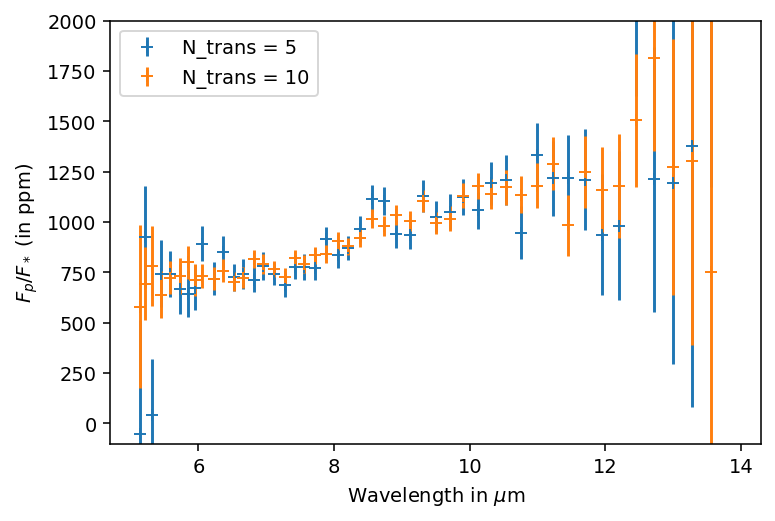

In [4]:
# load and plot data to verify

data = np.loadtxt('simulated_data/LHS3844b_moon_Ntrans_5_data.txt')
wav_moon_5, data_moon_5, err_moon_5 = data[:,0], data[:,1], data[:,2]

data = np.loadtxt('simulated_data/LHS3844b_moon_Ntrans_10_data.txt')
wav_moon_10, data_moon_10, err_moon_10 = data[:,0], data[:,1], data[:,2]

plt.plot()
plt.errorbar(wav_moon_5, 10**6*data_moon_5, yerr=10**6*err_moon_5, ls='', fmt='+', label='N_trans = 5')
plt.errorbar(wav_moon_10, 10**6*data_moon_10, yerr=10**6*err_moon_10, ls='', fmt='+', label='N_trans = 10')
plt.ylabel('$F_p/F_*$ (in ppm)')
plt.xlabel('Wavelength in $\mu$m')
plt.ylim((-100,2000))
plt.legend()


Cool. Now, let's write the dynesty functions

First, for the N_trans=5 case

In [19]:
# load the three mineral models

data = np.loadtxt('./simulated_data/xrp/basalt.txt')
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/dunite.txt')
wav_dunite, spec_dunite = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/granite.txt')
wav_granite, spec_granite = data[:,0], data[:,1]

# get them all to the same wavelength axes

spec_basalt = spectres(wav_dunite, wav_basalt, spec_basalt)
spec_granite = spectres(wav_dunite, wav_granite, spec_granite)

wav_basalt = np.copy(wav_dunite)
wav_granite = np.copy(wav_dunite)

In [20]:
# define data and noise

wav_data, data, noise = wav_moon_5, data_moon_5, err_moon_5

Now run a model with one rock at a time, and perform model comparisons between them

First basalt

In [21]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_moon_5)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_basalt = theta

    # calculate the total spectrum as the linear sum

    spec_total = f_basalt*spec_basalt

    # bin total spectrum to data array

    spec_total = spectres(wav_data, wav_basalt, spec_total)
    
    chisq = -0.5*np.sum((spec_total-data)**2/(noise)**2)

    return chisq + norm_log



In [22]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 3408 | +512 | bound: 4 | nc: 1 | ncall: 22308 | eff(%): 17.985 | loglstar:   -inf < 331.501 <    inf | logz: 327.202 +/-  0.083 | dlogz:  0.000 >  0.100                                        

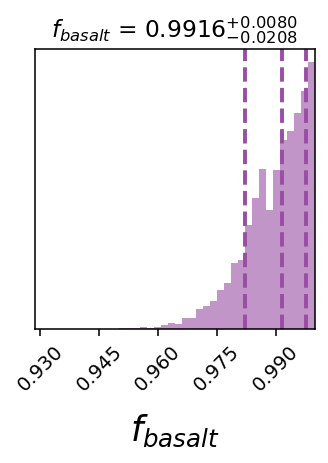

In [23]:
# plot posteriors

labels=['$f_{basalt}$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                    title_fmt='.4f',label_kwargs={'fontsize':label_font}, 
                    hist2d_kwargs={'plot_contours':True,'fill_contours':True});

In [37]:
#### evaluate chi squared

# calculate best fit model

f_ml = 0.992
spec_ml = f_ml*spec_basalt

# reduce the model to data's resolution

spec_ml_binned = spectres(wav_data, wav_basalt, spec_ml)

# evaluate chi-squared value

print('all wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2)/(wav_data.size - 1))

# evaluate chi-squared value between 8 and 12 microns

ind = np.where((wav_data >= 8) & (wav_data <= 12))

print('\n 8-12 microns wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2)/(wav_data[ind].size - 1))


all wavelengths: 

chi-squared:  101.17167908382285
reduced chi-squared:  2.152588916677082

 8-12 microns wavelengths: 

chi-squared:  36.729706763483904
reduced chi-squared:  1.9331424612359949


In [35]:
wav_data[ind].size

20

Granite

In [31]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_moon_5)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_granite = theta

    # calculate the total spectrum as the linear sum

    spec_total = f_granite*spec_granite

    # bin total spectrum to data array

    spec_total = spectres(wav_data, wav_basalt, spec_total)
    
    chisq = -0.5*np.sum((spec_total-data)**2/(noise)**2)

    return chisq + norm_log



In [32]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 4596 | +512 | bound: 6 | nc: 1 | ncall: 23025 | eff(%): 22.689 | loglstar:   -inf < 142.435 <    inf | logz: 135.814 +/-  0.105 | dlogz:  0.000 >  0.100                                        

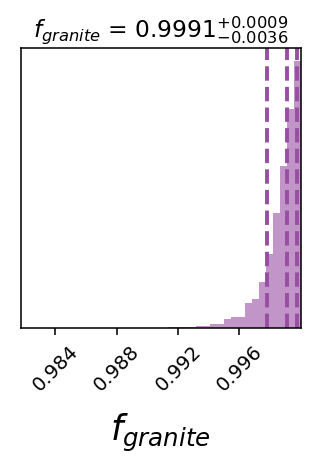

In [38]:
# plot posteriors

labels=['$f_{granite}$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                    title_fmt='.4f',label_kwargs={'fontsize':label_font}, 
                    hist2d_kwargs={'plot_contours':True,'fill_contours':True});

In [39]:
#### evaluate chi squared

# calculate best fit model

f_ml = 0.999
spec_ml = f_ml*spec_granite

# reduce the model to data's resolution

spec_ml_binned = spectres(wav_data, wav_granite, spec_ml)

# evaluate chi-squared value

print('all wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2)/(wav_data.size - 1))

# evaluate chi-squared value between 8 and 12 microns

ind = np.where((wav_data >= 8) & (wav_data <= 12))

print('\n 8-12 microns wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2)/(wav_data[ind].size - 1))


all wavelengths: 

chi-squared:  480.2589460231892
reduced chi-squared:  10.218275447301897

 8-12 microns wavelengths: 

chi-squared:  376.81584983140783
reduced chi-squared:  19.832413149021466


Now dunite

In [40]:
def prior(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    x = u   # since we are interest in abundances which are between 0 and 1

    return x

norm_log = -0.5*np.sum(np.log(2.0*np.pi*(err_moon_5)**2))

def loglik(theta):
    """
    The log-likelihood function.
    
    """
    # unpack parameters

    f_dunite = theta

    # calculate the total spectrum as the linear sum

    spec_total = f_dunite*spec_dunite

    # bin total spectrum to data array

    spec_total = spectres(wav_data, wav_basalt, spec_total)
    
    chisq = -0.5*np.sum((spec_total-data)**2/(noise)**2)

    return chisq + norm_log



In [41]:
nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 1       # number of parameters
sample = 'unif'  # sampling scheme
tol = 0.1         # the stopping criterion

sampler = NestedSampler(loglik, prior, ndims,
                            bound=bound, sample=sample, nlive=nlive)
sampler.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 4696 | +512 | bound: 7 | nc: 1 | ncall: 23853 | eff(%): 22.313 | loglstar:   -inf < 134.615 <    inf | logz: 127.801 +/-  0.107 | dlogz:  0.000 >  0.100                                        

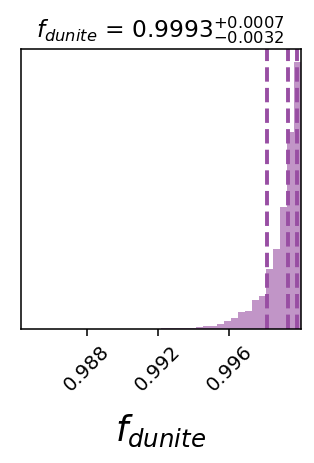

In [43]:
# plot posteriors

labels=['$f_{dunite}$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                    title_fmt='.4f',label_kwargs={'fontsize':label_font}, 
                    hist2d_kwargs={'plot_contours':True,'fill_contours':True});

In [44]:
#### evaluate chi squared

# calculate best fit model

f_ml = 0.999
spec_ml = f_ml*spec_dunite

# reduce the model to data's resolution

spec_ml_binned = spectres(wav_data, wav_dunite, spec_ml)

# evaluate chi-squared value

print('all wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned-data)**2/(noise)**2)/(wav_data.size - 1))

# evaluate chi-squared value between 8 and 12 microns

ind = np.where((wav_data >= 8) & (wav_data <= 12))

print('\n 8-12 microns wavelengths: \n')
print('chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2))
print('reduced chi-squared: ', np.sum((spec_ml_binned[ind]-data[ind])**2/(noise[ind])**2)/(wav_data[ind].size - 1))


all wavelengths: 

chi-squared:  496.1706390338942
reduced chi-squared:  10.556822107104132

 8-12 microns wavelengths: 

chi-squared:  281.0270451415687
reduced chi-squared:  14.790897112714141


In [45]:
wav_data.size, wav_data[ind].size

(48, 20)

In [35]:
# Preference of basalt model over granite model

B, sigma = Z_to_sigma(327, 135)
sigma

19.752372890398245

In [36]:
# Preference of basalt model over dunite model

B, sigma = Z_to_sigma(327, 127)
sigma

20.154295749402866

## Plot for the proposal

In [35]:
R = 50

# load outputs from run

out_moon = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_moon.p','rb'))
x_moon_5,y_moon_5,e_moon_5 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=5, model=True, plot=False)
x_moon_10,y_moon_10,e_moon_10 = jpi.jwst_1d_spec(out_moon, R=R/2, num_tran=10, model=True, plot=False)

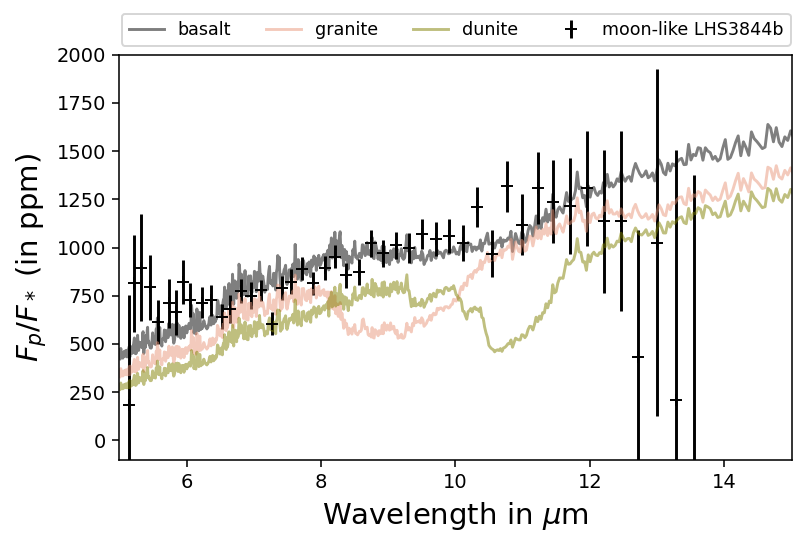

In [36]:
fig, ax = plt.subplots(nrows=1, figsize=(6,4))

data = np.loadtxt('./simulated_data/xrp/basalt.txt')
wav_basalt, spec_basalt = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/dunite.txt')
wav_dunite, spec_dunite = data[:,0], data[:,1]

data = np.loadtxt('./simulated_data/xrp/granite.txt')
wav_granite, spec_granite = data[:,0], data[:,1]

color_basalt= 'black'
color_dunite = 'olive'
color_granite = 'darksalmon'

ax.errorbar(x_moon_5[0],10**6*y_moon_5[0], yerr=10**6*e_moon_5[0], ls='', fmt='+', label='moon-like LHS3844b', color='black')
ax.plot(wav_basalt, 10**6*spec_basalt, color=color_basalt,  alpha = 0.5, label='basalt')
ax.plot(wav_granite, 10**6*spec_granite, color=color_granite,  alpha = 0.5, label='granite')
ax.plot(wav_dunite, 10**6*spec_dunite, color=color_dunite,  alpha = 0.5, label='dunite')
ax.set_ylabel('$F_p/F_*$ (in ppm)', fontsize=15)
ax.set_xlabel('Wavelength in $\mu$m', fontsize=15)
ax.set_xlim((5,15))
ax.set_ylim((-100,2000))
#ax.set_title('N_trans = 5, R = 50')
ax.legend(loc='lower left', bbox_to_anchor=(-0.01,1.0), ncol=4, fontsize=9)

plt.tight_layout()

plt.savefig('Figures/xrp_figure.png', dpi=1000, format='png', bbox_inches='tight')